In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
np.random.seed(11)

First we read the Dataset and show the first 5 rows:

In [2]:
DFin = pd.read_csv('Roman Urdu DataSet.csv', header=None)
DFin.head()

,0,1,2
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,NaN
1,sahi bt h,Positive,NaN
2,"Kya bt hai,",Positive,NaN
3,Wah je wah,Positive,NaN
4,Are wha kaya bat hai,Positive,NaN


In [3]:
DFin.shape

(20229, 3)

In [4]:
DFin[2].unique()

array([nan, '----------------', '----------', '-------', '------', '9090',
       'till here'], dtype=object)

There's 20229 rows and 3 columns, the third column appears to be garbage so we drop it.

In [5]:
df = DFin.drop([2], axis = 1) 
df.head()

,0,1
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


In [6]:
df[1].unique()

array(['Positive', 'Neutral', 'Negative', 'Neative'], dtype=object)

Some labels are spelled incorrectly, we replace them

In [7]:
df[1]=df[1].replace('Neative','Negative')

In [8]:
df[1].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

Lets check the length of each of the texts to determine a consistent input length:

In [9]:
#get length of text
df[2] = df.apply(lambda row: len(str(row[0]).split()), axis=1)

In [10]:
df.head()

,0,1,2
0,Sai kha ya her kisi kay bus ki bat nhi hai lak...,Positive,25
1,sahi bt h,Positive,3
2,"Kya bt hai,",Positive,3
3,Wah je wah,Positive,3
4,Are wha kaya bat hai,Positive,5


In [11]:
df0 = df[df[2] == 0]
df0.shape

(112, 3)

In [12]:
df50 = df[df[2] > 50]
df50.shape

(406, 3)

In [13]:
leng = np.array(df.iloc[:, 2].values)
max(leng)

301

112 samples have an empty text, and are classified as neutral.

406 samples are longer than 50 words with the longest being 301.

Lets see the lengths on a histogram:

In [14]:
leng = leng[leng <= 50]

C:\Users\eric8\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


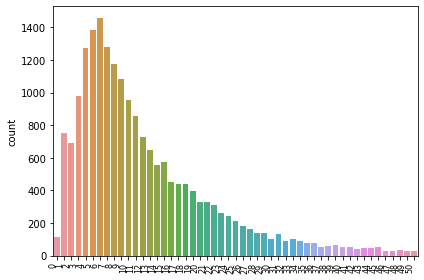

In [15]:
ax = sns.countplot(leng)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right", fontsize=8)
plt.tight_layout()
plt.show()

The highest point of the curve is around 7 words, having a low amount of samples over 30.

I decided to keep the long texts, but they will be truncated for the neural network input which will be 25 words.

In [16]:
# to remove long texts
#df = df[df[2] <= 50]

If we wanted to balance the dataset we could do it like this:

In [17]:
# to balance the dataset
#df = df.drop(df[df[1] == 'Neutral'].sample(frac=.5).index)

Remove everything besides letters from the texts.

In [18]:
def preproc(text):
  text = re.sub("[^A-Za-z]", ' ', str(text).lower())
  return text

In [19]:
x = np.array(df.iloc[:, 0].apply(preproc).values)
y = np.array(df.iloc[:, 1].values)
print(x)

['sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi aj aur aj bi sirf aus say bus'
 'sahi bt h' 'kya bt hai ' ...
 'bahi sayasat kufrrr ha saaaf bttttt ha qanon sirf allah ka calhay ga muslim country me sayasat ka kaaaam isreal ka ha'
 'aanti toh gussa e kr gai hain '
 'mai b sirf shadi kanry ki waja say imran khan ka sat dey raha hun ']


Lets see the distribution of the dataset classes:

C:\Users\eric8\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:ylabel='count'>

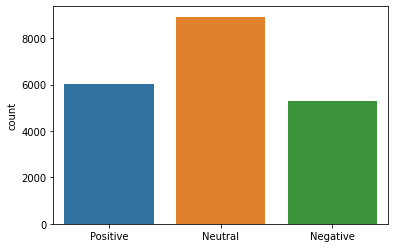

In [20]:
sns.countplot(y)

Transform the classes to a 3 column vector where each column represents a class.

In [21]:
d = {'Negative':0,'Neutral':1,'Positive':2}
yyy = np.vectorize(d.get)(y)
yyy = tf.keras.utils.to_categorical(yyy, 3)
print(yyy)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 0. 1.]]


Transform all the words in the dataset into numbers ordered by appereance frequency.

In [22]:
from tensorflow.keras.preprocessing.text import Tokenizer
tok = Tokenizer()
tok.fit_on_texts(x)

In [23]:
vocab_size = len(tok.word_index) + 1

In [24]:
vocab_size

31565

There are 31565 different words or tokens on the whole dataset, we will only take into account the 20000 most commmon words.

In [25]:
#transform the texts into sequences of tokens
sequens = tok.texts_to_sequences(x)
#make 20000 the maximum number for tokens
for i, x in enumerate(sequens):
    for j, a in enumerate(x):
        if a>20000:
            sequens[i][j] = 20000

In [26]:
wordlen = 25

Choosing a maximum length of 25 words we truncate the longer ones and fill with 0 the shorter ones.

In [27]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

xend = pad_sequences(sequens, maxlen = wordlen, padding='post', truncating='post')
xend.shape

(20229, 25)

We separate the training set from the testing set.

In [28]:
x_train, x_test, y_train, y_test = train_test_split(xend, yyy, test_size=0.15,random_state=11)

For our model we have to start by transforming our tokens into embedding vectors that give the information of each word.

In this case we used an embedding of 64 (longer ones didnt bring much improvement.)

We use an LSTM that goes backwards since urdu is written from right to left.

Finally a softmax layer to give the probability of each sample being on each class.

Some dropouts to delay overfitting.

Using categorical crossentropy since we are classifying more than 2 classes and an Adam optimizer which is the most commonly used.

In [29]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (Dense, Bidirectional, LSTM, 
                                     Dropout, Embedding)
from tensorflow.keras.optimizers import Adam

input_size = wordlen
model = Sequential()
model.add(Embedding(vocab_size, 64, input_length=input_size))
model.add(Dropout(0.3))
model.add(LSTM(16, go_backwards=True))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 64)            2020160   
_________________________________________________________________
dropout (Dropout)            (None, 25, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                5184      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 51        
Total params: 2,025,395
Trainable params: 2,025,395
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = model.fit(x_train, y_train, batch_size=128, validation_split=0.1, epochs=3, verbose=1)

Epoch 1/3
121/121 [==============================] - 3s 24ms/step - loss: 1.0147 - accuracy: 0.4932 - val_loss: 0.9175 - val_accuracy: 0.5924
Epoch 2/3
121/121 [==============================] - 2s 20ms/step - loss: 0.7979 - accuracy: 0.6596 - val_loss: 0.7677 - val_accuracy: 0.6785
Epoch 3/3
121/121 [==============================] - 2s 20ms/step - loss: 0.5608 - accuracy: 0.7854 - val_loss: 0.7699 - val_accuracy: 0.6866


(more epochs overfit the model)

In [31]:
model.evaluate(x_test, y_test)

95/95 [==============================] - 0s 2ms/step - loss: 0.7831 - accuracy: 0.6755


[0.7830504179000854, 0.6754530668258667]

67% test accuracy

In [32]:
scores = model.predict(x_test, verbose=1, batch_size=128)
pred_lstm = [np.argmax(score) for score in scores]
y_test = [np.argmax(y) for y in y_test]

24/24 [==============================] - 0s 3ms/step


In [33]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test,pred_lstm))
print(accuracy_score(y_test, pred_lstm))

              precision    recall  f1-score   support

           0       0.64      0.57      0.60       800
           1       0.67      0.78      0.72      1350
           2       0.71      0.61      0.66       885

    accuracy                           0.68      3035
   macro avg       0.68      0.65      0.66      3035
weighted avg       0.68      0.68      0.67      3035

0.6754530477759473


In [34]:
len(y_test)

3035

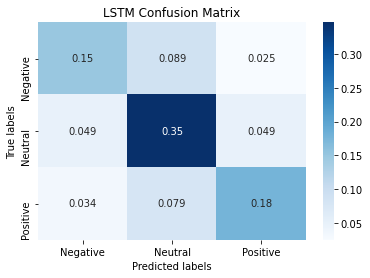

In [35]:
cm = confusion_matrix(y_test, pred_lstm)/3035
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('LSTM Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'])
ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'])
plt.show()

Now lets make our predictions lean more towards the negative side as per customer request:

We accomplish this by adding 0.3 to the probability of each sample being negative.

In [36]:
scores[:,0] += 0.3

In [37]:
pred_lstm_neg = [np.argmax(score) for score in scores]
print(classification_report(y_test,pred_lstm_neg))
print(accuracy_score(y_test, pred_lstm_neg))

              precision    recall  f1-score   support

           0       0.56      0.69      0.62       800
           1       0.70      0.71      0.71      1350
           2       0.73      0.56      0.63       885

    accuracy                           0.66      3035
   macro avg       0.66      0.65      0.65      3035
weighted avg       0.67      0.66      0.66      3035

0.6606260296540363


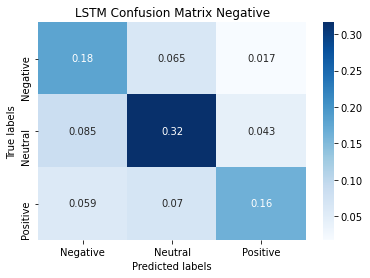

In [38]:
cm = confusion_matrix(y_test, pred_lstm_neg)/3035
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('LSTM Confusion Matrix Negative')
ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'])
ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'])
plt.show()

This way it leans more towards the negative class by having the biggest recall.

Another way to achieve this could be to have more negative samples on the dataset.

Lets compare our network to a Support Vector Classifier:

First we split the original dataset with only letters on the text.

In [39]:
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:, 0].apply(preproc).values, df.iloc[:, 1].values, test_size=0.15,random_state=11)

Using term frequency times the inverse document frequency to represent each of the words in our texts

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(use_idf = True)
train_vectors = vectorizer.fit_transform(x_train)
test_vectors = vectorizer.transform(x_test)

We use an SVC with an rbf kernel

In [41]:
from sklearn import svm

ur_svm = svm.SVC(kernel='rbf')
ur_svm.fit(train_vectors, y_train)

pred_svm = ur_svm.predict(test_vectors)
print(classification_report(y_test,pred_svm))

              precision    recall  f1-score   support

    Negative       0.65      0.44      0.53       800
     Neutral       0.64      0.82      0.72      1350
    Positive       0.68      0.58      0.63       885

    accuracy                           0.65      3035
   macro avg       0.66      0.61      0.62      3035
weighted avg       0.65      0.65      0.64      3035



In [42]:
acc_svm = accuracy_score(y_test, pred_svm)
print(acc_svm)

0.6507413509060955


In [43]:
len(y_test)

3035

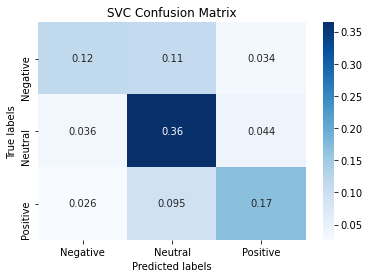

In [44]:
cm = confusion_matrix(y_test, pred_svm)/3035
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap="Blues")
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('SVC Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative','Neutral','Positive'])
ax.yaxis.set_ticklabels(['Negative','Neutral','Positive'])
plt.show()

Discussion:

The LSTM network has better accuracy (67%), even when modified to lean towards the negative (66%). 

The LSTM would be my choice.

I did not use anything specific to any language (Stopwords, lemmatization, etc.).

Both models and their preprocessing could be used for any language as long as you train them with the new language. 

Data limitations:

I do not know urdu, but many samples after translation didnt seem to be related to the sentiment they were labeled with.

Positive examples:

What idol is

Hey what's the matter 

What he wrote 


There might be mislabeled data or I am not aware of the specifics of the language.

According to the creators of the dataset Roman Urdu is not standarized which is why they created this dataset following their own rules.

"Roman Urdu lacks standard lexicon and usually many spelling variations exist for a given word"

Sharf, Z. and S. Rahman. “Lexical normalization of roman Urdu text.” (2018).

If we were to create a larger dataset, we would have to follow the same rules to normalize roman urdu across all samples.

Even with such a low accuracy, determining a global customer sentiment would not be impacted too much 

for a large enough dataset since missclasifications in all classes would average out.